#Informe final de carrera

*** Santiago Restrepo Alzate - DS-ONLINE-20 ***

*** Este notebook se puede acceder en github: DS_Informe_final.ipynb ***
---
https://github.com/santyres/Acamica-DS

Aplicación de NLP para predicción de sentimientos.

Este informe final tiene como objetivo investigar y experimentar técnicas alternativas para abordar el tema de clasificación de las reviews de productos en positivas o negativas (clasificación binaria) y responder a las preguntas que nos plantearemos para desarrollar el informe.

Tomaremos como punto de partida el modelo entregado en el proyecto 3 del curso, en el cual usamos algoritmos de Machine Learning para entrenar un clasificador de sentimientos para las reviews de productos.  A partir de este punto evaluaremos nuevas aproximaciones para dar respuesta a las siguientes preguntas:

1. Cuáles otras transformaciones o estrategias de preprocesamiento de datos podrían mejorar el desempeño de nuestro modelo?

2. Este problema de clasificación se puede abordar con otras técnicas como son las redes neuronales o los word embeddings?

Lo que esperamos es que, resolviendo las dos preguntas anteriores, podamos obtener un modelo equivalente o mejor que el modelo obtenido en el proyecto 3.

#Primer modelo

Partiremos del modelo obtenido en el proyecto 3

In [1]:
import pandas as pd
import itertools
from random import randint
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import nltk
nltk.download('punkt')
nltk.download('stopwords')

import gensim
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Instalar paquete de lenguaje español para la librería spacy
!python -m spacy download es_core_news_md

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


In [3]:
#Importar paquete de lenguaje en español para la librería spacy
import es_core_news_md
nlp = es_core_news_md.load()

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Cargar datos de entrenamiento
df = pd.read_json("dataset_es_train.json", lines=True)

#reagrupar las estrellas (calificaciones) para generar las etiquetas positivas y negativas
df = df[df.stars != 3]

#Crear una nueva columna con el sentimiento (1:positivo o 0:negativo) para redefinir la etiqueta para el modelo
df["sentimiento"] = df["stars"].map(lambda x : "0" if (x <= 2) else "1",na_action=None)
df.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,sentimiento
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics,0
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics,0
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore,0
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless,0
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes,0


In [5]:
#método para generar la matriz de confusión
def confusion(ytest,y_pred):
    names=["1","2","3","4","5"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

#Metodo para normalizar los datos
def normalizar_datos(df, stopwords_exceptions, num_filtered_chars):
  stopwords = nltk.corpus.stopwords.words('spanish')
  # stopwords = spacy.lang.es.stop_words.STOP_WORDS

  #Elimina las excepciones que se quieren hacer sobre la lista de stopwords
  for w in stopwords_exceptions:
    stopwords.remove(w)
    print(f"palabra '{w}' eliminada de la lista de stopwords!")

  palabras_lemma = []

  #Realizar tokenizado y lemmatizado para cada review, se optimiza el pipeline de spacy para mejorar el performance.
  for doc in nlp.pipe(list(df.review_body), disable=["tagger", "parser","ner","textcat","custom"]): #recorre reviews
    #recorre los tokens para extraer lemmas de las palabras
    lemma = [token.lemma_.lower() for token in doc if token.text not in stopwords #elimina stopwords
                                                  if token.text.isalpha() #elimina numeros y puntuación
                                                  if len(token.text) > num_filtered_chars] #elimina palabras con menos de 3 caracteres
    lemma = " ".join(lemma)
    palabras_lemma.append(lemma)

  df["review_body_lemma"] = palabras_lemma
  return df

#Metodo para vectorizar los datos y entregar los set de datos de train y test
def train_test_vectorized(df):
  # Usaremos solo las 2000 palabras con mas frecuencia en todo el corpus para generar los vectores, para optimizar la memoria
  max_features=2000
  vectorizer = TfidfVectorizer(max_features=max_features)

  reviews = list(df.review_body_lemma.values)
  stars = df.sentimiento.values

  X = vectorizer.fit_transform(reviews)

  x = X.toarray()
  y = stars

  #Creamos los conjuntos de train y test para el entrenamiento del modelo
  return train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

#Metodo para vectorizar los datos usando 1-gram y 2-gram y entregar los set de datos de train y test
def train_test_vectorized_2grams(df):
  # Usaremos solo las 2000 palabras con mas frecuencia en todo el corpus para generar los vectores, para optimizar la memoria
  max_features=2000
  vectorizer = TfidfVectorizer(max_features=max_features, analyzer='word', ngram_range=(1, 2)) #generar vectores con 1 gram y 2 gram

  reviews = list(df.review_body_lemma.values)
  stars = df.sentimiento.values

  X = vectorizer.fit_transform(reviews)

  x = X.toarray()
  y = stars

  #Creamos los conjuntos de train y test para el entrenamiento del modelo
  return train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

Score: 0.8618125



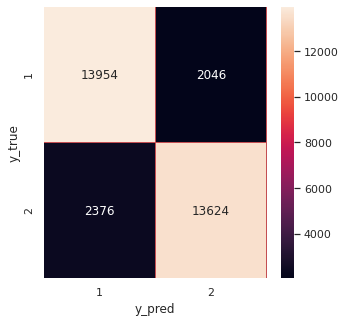

In [12]:
#Normalizar datos (sin exlcuir palabras del conjunto de stopwords y sacando las palabras que además tengas 3 o menos caracteres)
df = normalizar_datos(df, "", 3)
#Vectorizar datos y generar el set de datos de train y test
xtrain, xtest, ytrain, ytest = train_test_vectorized(df)

#Entrenar modelo
from sklearn.svm import LinearSVC
svc = LinearSVC(C = 0.1, random_state=42, loss='squared_hinge')
svc.fit(xtrain,ytrain)
print("Score: "+str(svc.score(xtest,ytest))+'\n')
y_pred = svc.predict(xtest)
confusion(ytest,y_pred)

Score del modelo seleccionado en el proyecto 3: 0.861

#Pregunta 1:

1. Cuáles otras transformaciones o estrategias de preprocesamiento de datos podrían mejorar el desempeño de nuestro modelo?

  1.1 **Adicionar el título al texto de cada review**. Los titulos de los reviews pueden contener palabras claves para el clasificador, pueden ser mas concretos a la hora de describir el sentimiento. Si agregamos estas palabras al corpus de los reviews, el clasificador podría ajustar mejor sus patrones.

Score: 0.8961875



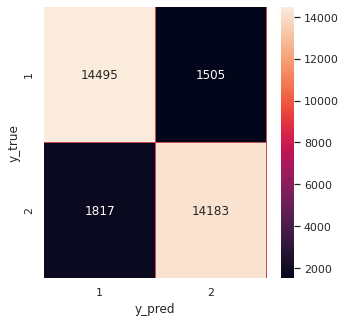

In [13]:
reviews_sin_titulo = df.review_body.copy()

#Adicionar el titulo al cuerpo de cada revisión.
df["review_body"] = df["review_title"]  + ", " + df["review_body"]

reviews_con_titulo = df.review_body

#Normalizar datos (sin exlcuir palabras del conjunto de stopwords y sacando las palabras que además tengan 3 o menos caracteres)
df = normalizar_datos(df, "", 3)
xtrain, xtest, ytrain, ytest = train_test_vectorized(df)

#Entrenamos nuevamente el modelo LinearSVC
from sklearn.svm import LinearSVC
svc = LinearSVC(C = 0.1, random_state=42, loss='squared_hinge')
svc.fit(xtrain,ytrain)
print("Score: "+str(svc.score(xtest,ytest))+'\n')
y_pred = svc.predict(xtest)
confusion(ytest,y_pred)

Nota: logramos subir unos puntos en el accuracy (de 0.86 a 0.89) del modelo agregando los títulos a cada review, miremos cuantas palabras nuevas agregamos al modelo.

In [14]:
stopwords = nltk.corpus.stopwords.words('spanish')

#Calculemos las frecencias para las reviews sin el titulo agregado
palabras_reviews_sin_titulo = []
lemmas = []

#Tokenizar y lemmatizar
for doc in nlp.pipe(list(reviews_sin_titulo), disable=["tagger", "parser","ner","textcat","custom"]): #recorre reviews
  lemma = [token.lemma_.lower() for token in doc if token.text not in stopwords #elimina stopwords
                                                  if token.text.isalpha() #elimina numeros y puntuación
                                                  if len(token.text) > 3] #elimina palabras con menos de 3 caracteres
  lemmas.append(lemma)
palabras_reviews_sin_titulo = list(itertools.chain(*lemmas))

#calcula la frecuencia de aparición de cada palabra
freq = nltk.FreqDist(palabras_reviews_sin_titulo)
df_palabras_reviews_sin_titulo = pd.DataFrame(list(freq.items()), columns = ["palabras","frecuencia"])
df_palabras_reviews_sin_titulo.sort_values("frecuencia",ascending=False,inplace=True)

#Calculemos las frecuencias para las reviews con el titulo agregado
palabras_reviews_con_titulo = []
lemmas = []

#Tokenizar y lemmatizar
for doc in nlp.pipe(list(reviews_con_titulo), disable=["tagger", "parser","ner","textcat","custom"]): #recorre reviews
  #recorre los tokens para extraer lemmas de las palabras
  lemma = [token.lemma_.lower() for token in doc if token.text not in stopwords #elimina stopwords
                                                  if token.text.isalpha() #elimina numeros y puntuación
                                                  if len(token.text) > 3] #elimina palabras con menos de 3 caracteres
  lemmas.append(lemma)
palabras_reviews_con_titulo = list(itertools.chain(*lemmas))

#calcula la frecuencia de aparición de cada palabra
freq = nltk.FreqDist(palabras_reviews_con_titulo)
df_palabras_reviews_con_titulo = pd.DataFrame(list(freq.items()), columns = ["palabras","frecuencia"])
df_palabras_reviews_con_titulo.sort_values("frecuencia",ascending=False,inplace=True)

print(f"Con la inclusión del título en el texto del review logramos incrementar el corpus de palabras en {len(df_palabras_reviews_con_titulo) - len(df_palabras_reviews_sin_titulo)}")

# palabras_nuevas = []
# revisiones_sin_titulo = list(df_palabras_reviews_sin_titulo.palabras.head(50))
# for p in list(df_palabras_reviews_con_titulo.palabras.head(50)):
#   if p not in revisiones_sin_titulo:
#     palabras_nuevas.append(p)

Con la inclusión del título en el texto del review logramos incrementar el corpus de palabras en 3496


1.2 **Remover la palabra "No" de la lista de stopwords**.   Esto podría ayudar a mejorar la conformación de patrones del algoritmo, ya que las negaciones, en muchos casos, pueden dar el sentido negativo o positivo en una revisión.  Ejemplo: "*producto recibido*" podría configurar una revisión como positiva, por el contrario, "*producto no recibido*" podría configurar una revisión como negativa.

Para esto también tenemos que tomar la decisión de conservar las palabras de 2 o mas caracteres.

palabra 'no' eliminada de la lista de stopwords!
Score: 0.91309375



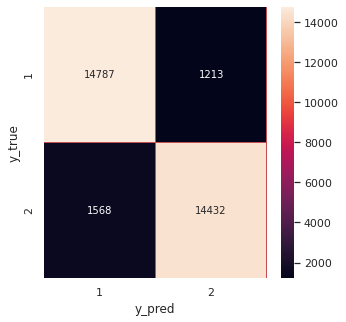

In [8]:
#Normalizar datos (exlcuir la palabra "no" del conjunto de stopwords y conservar sólo las palabras que tengan 2 o más caracteres)
df = normalizar_datos(df, ["no"], 1)
xtrain, xtest, ytrain, ytest = train_test_vectorized(df)

#Entrenamos nuevamente el modelo LinearSVC
from sklearn.svm import LinearSVC
svc = LinearSVC(C = 0.1, random_state=42, loss='squared_hinge')
svc.fit(xtrain,ytrain)
print("Score: "+str(svc.score(xtest,ytest))+'\n')
y_pred = svc.predict(xtest)
confusion(ytest,y_pred)

Nota: conservando la palabra "No" en las revisiones logramos subir un poco el accuracy del modelo (de 0.89 a 0.91)

1.3 **Vectorizar las palabras por pares (bigramas)** podría darle mas contexto a los reviews.   por ejemplo:

La palabra "calidad" por si sola podría ser ambigua a la hora de clasificar un review como negativo o positivo, pero si la combinamos con otra palabra como "discutible" tendríamos "calidad discutible" que podría encajar dentro de las expresiones comunes para reviews negativas o si la combinamos con la palabra "garantizada" tendríamos "calidad garantizada" que podría encajar dentro de las expresiones comunes para reviews positivas.

palabra 'no' eliminada de la lista de stopwords!
Score: 0.9215



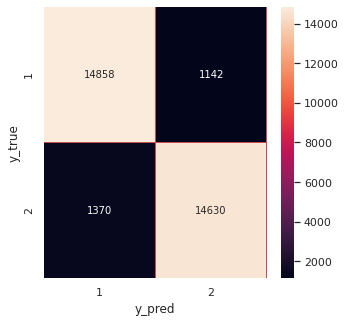

In [7]:
#Normalizar datos (exlcuir la palabra "no" del conjunto de stopwords y conservar sólo las palabras que tengan 2 o más caracteres)
df = normalizar_datos(df, ["no"], 1)
#Crear los set de entrenamiento y prueba con bigramas (configurado para realizar 1gram y 2gram)
xtrain, xtest, ytrain, ytest = train_test_vectorized_2grams(df)

#Entrenamos nuevamente el modelo LinearSVC
from sklearn.svm import LinearSVC
svc = LinearSVC(C = 0.1, random_state=42, loss='squared_hinge')
svc.fit(xtrain,ytrain)
print("Score: "+str(svc.score(xtest,ytest))+'\n')
y_pred = svc.predict(xtest)
confusion(ytest,y_pred)

Nota: Al incluir vectores conformados por palabras por pares (bigramas) mejoró  un poco la metrica del modelo (de 0.913 a 0.921), podemos concluir que el argumento expuesto para sustentar esta estrategia es válido en este contexto y para este caso de uso en particular.

#Respuesta:

Despues de explorar 3 nuevas estrategias en el preprocesamiento de los datos, podemos decir que todas nos ayudaron a mejorar el score del modelo, pasando de 0.861 a 0.921.  Las estrategias fueron: adicionar el titulo del texto a cada review, remover la palabra "no" de la lista de stopwords (con esta última tambien tomamos la decisión de conservar las palabras con 2 o mas caracteres de longitud) e incluir vectores conformados con pares de palabras (bigrams). Esto nos permitió aumentar la cantidad de palabras y expresiones para que el algoritmo tuviera mejores posibilidades de aprender a cerca de los reviews positivos y los reviews negativos y mejorar su desempeño.

#Pregunta 2:

2. Este problema de clasificación se puede abordar con otras técnicas como son las redes neuronales o los word embeddings?

  2.1 **Consideremos el uso de los word embeddings** como una alternativa al TfidfVectorizer. En las incrustaciones, cada palabra está representada por un vector de valor real, que generalmente tiene decenas o cientos de dimensiones a diferencia de las miles o millones de dimensiones necesarias para las representaciones de palabras en vectores sparce como ocurre cuando usamos 
OneHotEncoder. Las incrustaciones de palabras pueden reducir drásticamente el número de dimensiones necesarias para representar un documento de texto, además, éstas capturan el contexto y la semántica de las oraciones, ya que cada representación de vector de palabra se basa en su significado contextual.

  Para el problema de clasificación que nos ocupa, usaremos un word embedding pre-entrenado y veremos si las incrustaciones de palabras son aplicables a nuestro caso de uso y cuál será el efecto sobre el modelo de aprendizaje.

  El embedding usado puede descargase del siguiente repositorio:
  https://eafit-my.sharepoint.com/:u:/g/personal/srestr63_eafit_edu_co/ERktMgNfWAdDsLuFT9qEDCgBUEYPldH0ZudsKNvFbjL2ig?e=xeGmJh

In [9]:
#Con respecto al embedding que usaremos:
#https://github.com/dccuchile/spanish-word-embeddings
#http://crscardellino.github.io/SBWCE/

# cargar el word embedding pre-entrenado en español. Cada palabra está representada por un vector de 300 posiciones.
model = gensim.models.KeyedVectors.load_word2vec_format(
    os.path.join(os.getcwd(), 'SBW-vectors-300-min5.txt'),
    binary=False,
    unicode_errors='ignore'
)

#validamos el tamaño de la dimension para una palabra en el embedding
# len(model['comida'])
model.vector_size
#este script puede tomar 5 minutos para procesar

300

Ahora tenemos vectores de 300 posiciones para representar palabras en lugar de vectores de 2000 posiciones.  Vamos a usar este embedding para vectorizar nuestras reviews y obtener los features que usaremos para entrenar de nuevo nuestro modelo.

In [10]:
#Normalizar datos (exlcuir la palabra "no" del conjunto de stopwords y conservar sólo las palabras que tengan 2 o más caracteres)
df = normalizar_datos(df, ["no"], 1)

palabra 'no' eliminada de la lista de stopwords!


In [20]:
import numpy as np
#Para encontrar el vector de una revisión completa, obtenemos el vector de cada palabra de la revisión por separado y tomamos un promedio simple. 
review_embeddings = []

for doc in nlp.pipe(list(df.review_body_lemma), disable=["tagger", "parser","ner","textcat","custom"]):
    review_average = np.zeros(model.vector_size)
    count_val = 0

    for token in doc:
        if(token.text.lower() in model):
            review_average += model[token.text.lower()]
            count_val += 1
    review_embeddings.append(list(review_average/count_val))
    
print(f"Cantidad de reviews en el embedding: {len(review_embeddings)}")
print(f"Longitud de cada review en el embedding: {len(review_embeddings[0])}")

Cantidad de reviews en el embedding: 160000
Longitud de cada review en el embedding: 300


In [21]:
#Crear un dataframe con los vectores que representan cada review y rellenar las posiciones que puedan estar vacías
# embedding_data.isnull().sum()
embedding_data = pd.DataFrame(review_embeddings)
embedding_data = embedding_data.fillna(0)

#obtener los set de datos de entreniamiento y prueba
xtrain, xtest, ytrain, ytest = train_test_split(embedding_data,df.sentimiento,test_size=0.2,random_state=42,stratify=df.sentimiento)

Score: 0.88103125



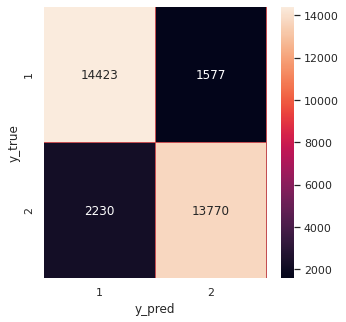

In [22]:
#Entrenamos nuevamente el modelo LinearSVC
from sklearn.svm import LinearSVC
svc = LinearSVC(C = 0.1, random_state=42, loss='squared_hinge')
svc.fit(xtrain,ytrain)
print("Score: "+str(svc.score(xtest,ytest))+'\n')
y_pred = svc.predict(xtest)
confusion(ytest,y_pred)

Nota: Desafortunadamente, obtuvimos un score ligeramente menor a nuestro modelo vectorizado con TfidfVectorizer, aunque las incrustaciones de palabras fueron realmente efectivas para reducir el número total de dimensiones, no fueron útiles para obtener un mejor modelo, además no nos facilitan interpretar y diagnosticar qué está causando su desempeño por debajo del deseado.

2.2 Consideremos el uso de una red neuronal para el problema de clasificación. Usaremos el perceptrón multicapa implementado con sklearn.  Es un modelo mas antigüo y simple que los modelos complejos de la era actual, aunque suficientemente complejo para distinguir datos que no son linealmente separables.  Lo seleccionamos como punto de partida para esta aproximación, para evitar profundizar en conceptos mas complejos que tendrían que considerarse a la hora de escoger otro modelo de red neuronal.

Perceptron multicapa (MLP: multi layer perceptron) es un tipo de red neuronal donde varias capas de un grupo de perceptrones se apilan juntas para hacer un modelo. (Recordemos que un perceptron representa una neurona, y una neurona la podemos asimilar como un modelo lineal que toma múltiples entradas y produce una salida). En nuestro caso, perceptron es un modelo lineal que toma un montón de entradas, las multiplica por valores llamados pesos y añade un término de sesgo para generar una salida.

El perceptrón multicapa es una red neuronal artificial (RNA) formada por múltiples capas. Dado que combinar funciones lineales sólo da como resultado otra salida lineal, las RNA incluyen (en sus capas ocultas) una función no lineal para que el MLP sea flexible y aprenda límites de decisión no lineales. Esta función es conocida como la función de activación.

Las capas se pueden clasificar en:

Capa de entrada: Constituida por aquellas neuronas que introducen los patrones de entrada en la red. En estas neuronas no se produce procesamiento.

Capas ocultas: Formada por aquellas neuronas cuyas entradas provienen de capas anteriores y cuyas salidas pasan a neuronas de capas posteriores.

Capa de salida: Neuronas cuyos valores de salida se corresponden con las salidas de toda la red.

Entrenemos un MLPClassifier con sus parámetros por definición:
- Activación: Relu (función de activación)
- Alpha: 0.0001 (Regularización L2)
- hidden_layer_sizes: 100 (una capa oculta de 100 neuronas)
- Solver: adam (adam: stochastic gradient-based optimizer, para la optimización de los pesos)
- Learning rate: constante, inicializado en 0.001

palabra 'no' eliminada de la lista de stopwords!
Iteration 1, loss = 0.26629385
Iteration 2, loss = 0.20016812
Iteration 3, loss = 0.19589085
Iteration 4, loss = 0.19283500
Iteration 5, loss = 0.18978366
Iteration 6, loss = 0.18661938
Iteration 7, loss = 0.18349304
Iteration 8, loss = 0.17996549
Iteration 9, loss = 0.17621993
Iteration 10, loss = 0.17220463
Iteration 11, loss = 0.16718220
Iteration 12, loss = 0.16148380
Iteration 13, loss = 0.15504873
Iteration 14, loss = 0.14742716
Iteration 15, loss = 0.13928722
Iteration 16, loss = 0.12991880
Iteration 17, loss = 0.12025287
Iteration 18, loss = 0.10968439
Iteration 19, loss = 0.09897960
Iteration 20, loss = 0.08830487
Iteration 21, loss = 0.07773695
Iteration 22, loss = 0.06801493
Iteration 23, loss = 0.05869203
Iteration 24, loss = 0.05049238
Iteration 25, loss = 0.04296968
Iteration 26, loss = 0.03631899
Iteration 27, loss = 0.03068573
Iteration 29, loss = 0.02182245
Iteration 30, loss = 0.01856906
Iteration 31, loss = 0.01588731


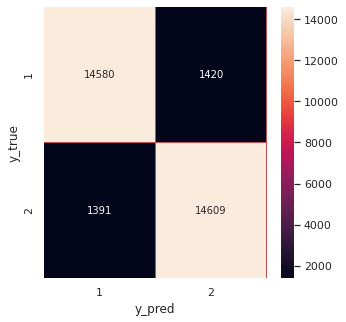

In [11]:
#Normalizar datos (exlcuir la palabra "no" del conjunto de stopwords y conservar sólo las palabras que tengan 2 o más caracteres)
df = normalizar_datos(df, ["no"], 1)
xtrain, xtest, ytrain, ytest = train_test_vectorized_2grams(df)

#Entrenamos el modelo MLPClassifier
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=42, verbose=True)
mlp.fit(xtrain,ytrain)
print("Score: "+str(mlp.score(xtest,ytest))+'\n')
y_pred = mlp.predict(xtest)
confusion(ytest,y_pred)
#Esta celda puede demorarse hasta 15 minutos en procesar

Muy bien!! con la red neuronal perceptrón multicapa obtuvimos un score de 0.912, prácticamente, logramos igualar el modelo lineal LinearSVC que entrenamos arriba con el cual obtuvimos un score de 0.921 -  Intentemos buscar mejores hiperparámetros para este modelo usando randomgridsearch. 

In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

parameters = {
            'hidden_layer_sizes':[(10,),(5,5),(100,),(50,50)],
            'alpha':10.0 ** -np.arange(1, 10)
            #  solver=['lbfgs','adam')
             }

mlp = MLPClassifier(random_state=42, verbose=True)
mlp_optimo = RandomizedSearchCV(mlp, parameters, scoring='accuracy', cv=3)
mlp_optimo.fit(xtrain,ytrain)
# mejor_modelo = RandomizedSearchCV(rfmodel, param_dist, n_iter=100, random_state=42, cv=5)
print("Mejores parametros: "+str(mlp_optimo.best_params_))
print("Mejor Score: "+str(mlp_optimo.best_score_)+'\n')

#*** Este script se demoró 5 horas en procesar ****

Iteration 1, loss = 0.45848482
Iteration 2, loss = 0.25626376
Iteration 3, loss = 0.22572295
Iteration 4, loss = 0.21686561
Iteration 5, loss = 0.21349849
Iteration 6, loss = 0.21173407
Iteration 7, loss = 0.21064822
Iteration 8, loss = 0.20983975
Iteration 9, loss = 0.20918793
Iteration 10, loss = 0.20838810
Iteration 11, loss = 0.20758148
Iteration 12, loss = 0.20680769
Iteration 13, loss = 0.20595102
Iteration 14, loss = 0.20509288
Iteration 15, loss = 0.20402998
Iteration 16, loss = 0.20307067
Iteration 17, loss = 0.20194743
Iteration 18, loss = 0.20083389
Iteration 19, loss = 0.19985142
Iteration 20, loss = 0.19885201
Iteration 21, loss = 0.19785088
Iteration 22, loss = 0.19689570
Iteration 23, loss = 0.19599833
Iteration 24, loss = 0.19510831
Iteration 25, loss = 0.19420157
Iteration 26, loss = 0.19331868
Iteration 27, loss = 0.19240735
Iteration 28, loss = 0.19156984
Iteration 29, loss = 0.19085943
Iteration 30, loss = 0.18995532
Iteration 31, loss = 0.18918160
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.45770816
Iteration 2, loss = 0.25448271
Iteration 3, loss = 0.22414330
Iteration 4, loss = 0.21539144
Iteration 5, loss = 0.21197100
Iteration 6, loss = 0.21030795
Iteration 7, loss = 0.20926525
Iteration 8, loss = 0.20861954
Iteration 9, loss = 0.20782158
Iteration 10, loss = 0.20712922
Iteration 11, loss = 0.20630661
Iteration 12, loss = 0.20559516
Iteration 13, loss = 0.20478001
Iteration 14, loss = 0.20388211
Iteration 15, loss = 0.20282961
Iteration 16, loss = 0.20185322
Iteration 17, loss = 0.20075302
Iteration 18, loss = 0.19963580
Iteration 19, loss = 0.19861981
Iteration 20, loss = 0.19754180
Iteration 21, loss = 0.19646222
Iteration 22, loss = 0.19548336
Iteration 23, loss = 0.19445917
Iteration 24, loss = 0.19354627
Iteration 25, loss = 0.19254870
Iteration 26, loss = 0.19156999
Iteration 27, loss = 0.19069876
Iteration 28, loss = 0.18984022
Iteration 29, loss = 0.18898550
Iteration 30, loss = 0.18809817
Iteration 31, loss = 0.18728941
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.45779813
Iteration 2, loss = 0.25390040
Iteration 3, loss = 0.22334502
Iteration 4, loss = 0.21463799
Iteration 5, loss = 0.21122086
Iteration 6, loss = 0.20960585
Iteration 7, loss = 0.20854787
Iteration 8, loss = 0.20794047
Iteration 9, loss = 0.20737984
Iteration 10, loss = 0.20673842
Iteration 11, loss = 0.20606620
Iteration 12, loss = 0.20540371
Iteration 13, loss = 0.20467999
Iteration 14, loss = 0.20386258
Iteration 15, loss = 0.20321999
Iteration 16, loss = 0.20227644
Iteration 17, loss = 0.20133942
Iteration 18, loss = 0.20041504
Iteration 19, loss = 0.19932980
Iteration 20, loss = 0.19832815
Iteration 21, loss = 0.19723673
Iteration 22, loss = 0.19626131
Iteration 23, loss = 0.19524855
Iteration 24, loss = 0.19427337
Iteration 25, loss = 0.19318948
Iteration 26, loss = 0.19232807
Iteration 27, loss = 0.19135490
Iteration 28, loss = 0.19044166
Iteration 29, loss = 0.18950079
Iteration 30, loss = 0.18854352
Iteration 31, loss = 0.18774308
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.31845014
Iteration 2, loss = 0.21972550
Iteration 3, loss = 0.21398210
Iteration 4, loss = 0.20991860
Iteration 5, loss = 0.20636983
Iteration 6, loss = 0.20262781
Iteration 7, loss = 0.19885386
Iteration 8, loss = 0.19513696
Iteration 9, loss = 0.19081375
Iteration 10, loss = 0.18636296
Iteration 11, loss = 0.18138782
Iteration 12, loss = 0.17527516
Iteration 13, loss = 0.16887464
Iteration 14, loss = 0.16121712
Iteration 15, loss = 0.15287029
Iteration 16, loss = 0.14365604
Iteration 17, loss = 0.13352856
Iteration 18, loss = 0.12325486
Iteration 19, loss = 0.11210238
Iteration 20, loss = 0.10120484
Iteration 21, loss = 0.09022470
Iteration 22, loss = 0.07979640
Iteration 23, loss = 0.07008193
Iteration 24, loss = 0.06100545
Iteration 25, loss = 0.05287603
Iteration 26, loss = 0.04531140
Iteration 27, loss = 0.03894931
Iteration 28, loss = 0.03336205
Iteration 29, loss = 0.02849493
Iteration 30, loss = 0.02426906
Iteration 31, loss = 0.02084746
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.45773881
Iteration 2, loss = 0.25438383
Iteration 3, loss = 0.22402782
Iteration 4, loss = 0.21526428
Iteration 5, loss = 0.21183397
Iteration 6, loss = 0.21016182
Iteration 7, loss = 0.20910943
Iteration 8, loss = 0.20845961
Iteration 9, loss = 0.20766014
Iteration 10, loss = 0.20697046
Iteration 11, loss = 0.20613164
Iteration 12, loss = 0.20540459
Iteration 13, loss = 0.20457438
Iteration 14, loss = 0.20367641
Iteration 15, loss = 0.20261034
Iteration 16, loss = 0.20162248
Iteration 17, loss = 0.20052334
Iteration 18, loss = 0.19940460
Iteration 19, loss = 0.19836607
Iteration 20, loss = 0.19726500
Iteration 21, loss = 0.19618142
Iteration 22, loss = 0.19520127
Iteration 23, loss = 0.19417783
Iteration 24, loss = 0.19326053
Iteration 25, loss = 0.19225519
Iteration 26, loss = 0.19126949
Iteration 27, loss = 0.19038669
Iteration 28, loss = 0.18950560
Iteration 29, loss = 0.18864006
Iteration 30, loss = 0.18774031
Iteration 31, loss = 0.18690727
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.45782341
Iteration 2, loss = 0.25379548
Iteration 3, loss = 0.22322685
Iteration 4, loss = 0.21450502
Iteration 5, loss = 0.21107294
Iteration 6, loss = 0.20944596
Iteration 7, loss = 0.20837525
Iteration 8, loss = 0.20775540
Iteration 9, loss = 0.20718173
Iteration 10, loss = 0.20652744
Iteration 11, loss = 0.20582844
Iteration 12, loss = 0.20513807
Iteration 13, loss = 0.20439834
Iteration 14, loss = 0.20357279
Iteration 15, loss = 0.20291304
Iteration 16, loss = 0.20194257
Iteration 17, loss = 0.20096296
Iteration 18, loss = 0.19999564
Iteration 19, loss = 0.19890741
Iteration 20, loss = 0.19789644
Iteration 21, loss = 0.19679511
Iteration 22, loss = 0.19582266
Iteration 23, loss = 0.19480042
Iteration 24, loss = 0.19382007
Iteration 25, loss = 0.19271975
Iteration 26, loss = 0.19183461
Iteration 27, loss = 0.19084461
Iteration 28, loss = 0.18992225
Iteration 29, loss = 0.18896119
Iteration 30, loss = 0.18799910
Iteration 31, loss = 0.18717961
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.34377257
Iteration 2, loss = 0.25633151
Iteration 3, loss = 0.25149072
Iteration 4, loss = 0.24876497
Iteration 5, loss = 0.24634436
Iteration 6, loss = 0.24292826
Iteration 7, loss = 0.24063358
Iteration 8, loss = 0.23878755
Iteration 9, loss = 0.23551053
Iteration 10, loss = 0.23352647
Iteration 11, loss = 0.23039625
Iteration 12, loss = 0.22752010
Iteration 13, loss = 0.22348997
Iteration 14, loss = 0.22000487
Iteration 15, loss = 0.21613952
Iteration 16, loss = 0.21209475
Iteration 17, loss = 0.20791884
Iteration 18, loss = 0.20396968
Iteration 19, loss = 0.20013635
Iteration 20, loss = 0.19642108
Iteration 21, loss = 0.19269772
Iteration 22, loss = 0.18991122
Iteration 23, loss = 0.18682815
Iteration 24, loss = 0.18364734
Iteration 25, loss = 0.18106422
Iteration 26, loss = 0.17837826
Iteration 27, loss = 0.17549020
Iteration 28, loss = 0.17316377
Iteration 29, loss = 0.17066306
Iteration 30, loss = 0.16887459
Iteration 31, loss = 0.16621997
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.49632564
Iteration 2, loss = 0.25934812
Iteration 3, loss = 0.22183018
Iteration 4, loss = 0.21395309
Iteration 5, loss = 0.21066386
Iteration 6, loss = 0.20892141
Iteration 7, loss = 0.20746579
Iteration 8, loss = 0.20645036
Iteration 9, loss = 0.20519590
Iteration 10, loss = 0.20419996
Iteration 11, loss = 0.20298307
Iteration 12, loss = 0.20188762
Iteration 13, loss = 0.20070806
Iteration 14, loss = 0.19950963
Iteration 15, loss = 0.19844567
Iteration 16, loss = 0.19726201
Iteration 17, loss = 0.19610316
Iteration 18, loss = 0.19481220
Iteration 19, loss = 0.19357787
Iteration 20, loss = 0.19236900
Iteration 21, loss = 0.19107729
Iteration 22, loss = 0.19009696
Iteration 23, loss = 0.18869645
Iteration 24, loss = 0.18766803
Iteration 25, loss = 0.18647947
Iteration 26, loss = 0.18526337
Iteration 27, loss = 0.18409474
Iteration 28, loss = 0.18302903
Iteration 29, loss = 0.18196713
Iteration 30, loss = 0.18078454
Iteration 31, loss = 0.17975082
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.49843184
Iteration 2, loss = 0.25943685
Iteration 3, loss = 0.22143466
Iteration 4, loss = 0.21349737
Iteration 5, loss = 0.21026955
Iteration 6, loss = 0.20834933
Iteration 7, loss = 0.20699353
Iteration 8, loss = 0.20587828
Iteration 9, loss = 0.20490228
Iteration 10, loss = 0.20373742
Iteration 11, loss = 0.20278487
Iteration 12, loss = 0.20176723
Iteration 13, loss = 0.20061510
Iteration 14, loss = 0.19945537
Iteration 15, loss = 0.19831655
Iteration 16, loss = 0.19722213
Iteration 17, loss = 0.19603688
Iteration 18, loss = 0.19484452
Iteration 19, loss = 0.19372660
Iteration 20, loss = 0.19243571
Iteration 21, loss = 0.19125445
Iteration 22, loss = 0.19010431
Iteration 23, loss = 0.18903262
Iteration 24, loss = 0.18797140
Iteration 25, loss = 0.18679765
Iteration 26, loss = 0.18565380
Iteration 27, loss = 0.18459432
Iteration 28, loss = 0.18359264
Iteration 29, loss = 0.18251003
Iteration 30, loss = 0.18161372
Iteration 31, loss = 0.18060297
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.45845129
Iteration 2, loss = 0.25610512
Iteration 3, loss = 0.22558264
Iteration 4, loss = 0.21672405
Iteration 5, loss = 0.21335062
Iteration 6, loss = 0.21158228
Iteration 7, loss = 0.21049025
Iteration 8, loss = 0.20967704
Iteration 9, loss = 0.20902402
Iteration 10, loss = 0.20822747
Iteration 11, loss = 0.20742864
Iteration 12, loss = 0.20665033
Iteration 13, loss = 0.20579191
Iteration 14, loss = 0.20492199
Iteration 15, loss = 0.20384610
Iteration 16, loss = 0.20287939
Iteration 17, loss = 0.20175159
Iteration 18, loss = 0.20061554
Iteration 19, loss = 0.19961234
Iteration 20, loss = 0.19859389
Iteration 21, loss = 0.19758248
Iteration 22, loss = 0.19660165
Iteration 23, loss = 0.19567504
Iteration 24, loss = 0.19477275
Iteration 25, loss = 0.19384464
Iteration 26, loss = 0.19295569
Iteration 27, loss = 0.19202541
Iteration 28, loss = 0.19117314
Iteration 29, loss = 0.19045083
Iteration 30, loss = 0.18953111
Iteration 31, loss = 0.18874660
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.45773820
Iteration 2, loss = 0.25438528
Iteration 3, loss = 0.22402895
Iteration 4, loss = 0.21526550
Iteration 5, loss = 0.21183555
Iteration 6, loss = 0.21016339
Iteration 7, loss = 0.20911121
Iteration 8, loss = 0.20846096
Iteration 9, loss = 0.20766158
Iteration 10, loss = 0.20697357
Iteration 11, loss = 0.20613664
Iteration 12, loss = 0.20541816
Iteration 13, loss = 0.20459054
Iteration 14, loss = 0.20369145
Iteration 15, loss = 0.20262369
Iteration 16, loss = 0.20163682
Iteration 17, loss = 0.20053445
Iteration 18, loss = 0.19941134
Iteration 19, loss = 0.19837260
Iteration 20, loss = 0.19727225
Iteration 21, loss = 0.19618637
Iteration 22, loss = 0.19520251
Iteration 23, loss = 0.19417717
Iteration 24, loss = 0.19326056
Iteration 25, loss = 0.19225428
Iteration 26, loss = 0.19126221
Iteration 27, loss = 0.19037548
Iteration 28, loss = 0.18949485
Iteration 29, loss = 0.18864003
Iteration 30, loss = 0.18774719
Iteration 31, loss = 0.18693315
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.45782471
Iteration 2, loss = 0.25379763
Iteration 3, loss = 0.22322835
Iteration 4, loss = 0.21450692
Iteration 5, loss = 0.21107483
Iteration 6, loss = 0.20944806
Iteration 7, loss = 0.20837847
Iteration 8, loss = 0.20775870
Iteration 9, loss = 0.20718672
Iteration 10, loss = 0.20653383
Iteration 11, loss = 0.20583461
Iteration 12, loss = 0.20514379
Iteration 13, loss = 0.20440182
Iteration 14, loss = 0.20357084
Iteration 15, loss = 0.20290347
Iteration 16, loss = 0.20192699
Iteration 17, loss = 0.20093984
Iteration 18, loss = 0.19996397
Iteration 19, loss = 0.19887437
Iteration 20, loss = 0.19785554
Iteration 21, loss = 0.19674470
Iteration 22, loss = 0.19576071
Iteration 23, loss = 0.19473052
Iteration 24, loss = 0.19373813
Iteration 25, loss = 0.19263971
Iteration 26, loss = 0.19173533
Iteration 27, loss = 0.19074296
Iteration 28, loss = 0.18982139
Iteration 29, loss = 0.18886724
Iteration 30, loss = 0.18791544
Iteration 31, loss = 0.18710208
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.32802504
Iteration 2, loss = 0.23396286
Iteration 3, loss = 0.22995874
Iteration 4, loss = 0.22728179
Iteration 5, loss = 0.22509482
Iteration 6, loss = 0.22270864
Iteration 7, loss = 0.22042932
Iteration 8, loss = 0.21827203
Iteration 9, loss = 0.21564186
Iteration 10, loss = 0.21329691
Iteration 11, loss = 0.21055448
Iteration 12, loss = 0.20720788
Iteration 13, loss = 0.20395337
Iteration 14, loss = 0.19991855
Iteration 15, loss = 0.19589399
Iteration 16, loss = 0.19137899
Iteration 17, loss = 0.18627913
Iteration 18, loss = 0.18157410
Iteration 19, loss = 0.17577898
Iteration 20, loss = 0.17046596
Iteration 21, loss = 0.16492652
Iteration 22, loss = 0.15929220
Iteration 23, loss = 0.15388240
Iteration 24, loss = 0.14881995
Iteration 25, loss = 0.14340684
Iteration 26, loss = 0.13828334
Iteration 27, loss = 0.13372775
Iteration 28, loss = 0.12954068
Iteration 29, loss = 0.12576622
Iteration 30, loss = 0.12192536
Iteration 31, loss = 0.11895411
Iteration 32, los

Mejores parametros: {'hidden_layer_sizes': (100,), 'alpha': 0.01}

Mejor Score: 0.9094374954112725


Score: 0.9115625



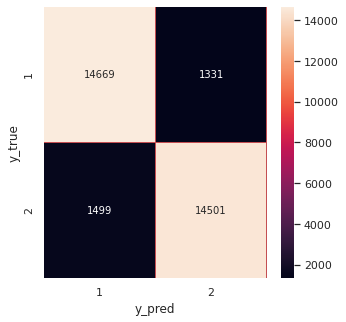

In [ ]:
print("Score: "+str(mlp_optimo.score(xtest,ytest))+'\n')
y_pred = mlp_optimo.predict(xtest)
confusion(ytest,y_pred)

Nota: Con la optimización de parámetros, no logramos una mejora considerable del modelo.

#Respuesta:

El uso de una red neuronal (en este caso el perceptrón multicapa) para entrenar un modelo de aprendizaje automático para clasificación de revisiones de productos (problema de clasificación binaria) resultó igualmente efectivo que un algoritmo de clasificación "tradicional" como el LinearSVC.  Al momento de decidir por uno de los dos modelos, elegiría el LinearSVC por su velocidad de entrenamiento.

#Conclusiones:

1. El **preprocesamiento de datos** es una etapa crucial a la hora de querer resolver un problema de aprendizaje automático.  A lo largo del curso, vimos  cómo un buen preprocesamiento de datos puede promover, en gran manera, el ajuste o la generalización que realizan los algoritmos: Rellenar valores faltantes, identificar y eliminar datos que pueden considerarse ruido, resolver redundancia, corregir inconsistencias, escalar datos, realizar transformaciones, convertir variables categóricas en variables numéricas, entre otros.

  Cuando recibimos un conjunto de datos, además de encontrar valores numéricos, en muchos casos, debemos trabajar también con datos no estructurados como texto, imágenes o vídeos.  El problema de aprendizaje automático que enfrentamos en este caso de uso, requirió realizar preprocesamiento del texto de las revisiones de los productos:

- Normalización: limpiar caracteres especiales y no deseados, pasar a minúsculas, tokenizar (separar el texto en palabras), lemmatizar (llevar las palabras a su raíz o a la forma base o diccionario de una palabra).

- Vectorización: convertir los textos a números (Encoders o word embeddings). Estrategias como eliminación de stopwords y tf-idf pueden ayudar en muchos casos a determinar la relevancia de las palabras para trabajar con aquellas que ayuden a extraer la información contenida en los textos.

  En nuestro caso de uso, conocer los datos nos permitió tomar la decisión de **agregar los títulos a las revisiones** para enriquecer el conjunto de palabras usadas para el entrenamiento, decidir **dejar la palabra "no"**, ya que las negaciones, en muchos casos, pueden dar el sentido negativo o positivo en una revisión y vectorizar las palabras usando **n-grams** para configurar expresiones de pares de palabras que fueran comunes en revisiones, tanto positivas como negativas.

2. La **experimentación** es una buena alternativa para lograr obtener un buen modelo de aprendizaje automático.  Usar diferentes algoritmos y técnicas, permite considerar diferentes opciones para buscar la mejor aproximación a la solución de un problema.

  En este caso de uso, pudimos seleccionar entre varios algoritmos para buscar el mejor modelo para clasificar las revisiones de productos, además, experimentamos con una red neuronal para validar su capacidad en el mencionado problema de clasificación.

3. Como solución al problema de clasificación de las revisiones de películas en español, seleccionamos el modelo LinearSVC por su velocidad de entrenamiento.

4. Existen aproximaciones mas complejas para abordar el problema de clasificación de nuestro caso de uso, sin embargo, preferimos una solución sencilla bien abordada, de acuerdo con los recursos de cómputo disponibles y los conocimientos adquiridos durante el curso, que otras mas ambiciosas y difíciles de sustentar.

---
/// Para mejorar el modelo en una próxima iteración ///

Para mejorar el modelo en una próxima iteración podríamos explorar las siguientes alternativas:

1. **Experimentar otras arquitecturas de redes neuronales** (las RNN: redes neuronales recurrentes son ampliamente usadas para trabajar con texto), incluyendo modelos con mas capas ocultas.
   Implementar las redes neuronales con Keras, que es una librería ampliamente usada, amigable para el usuario, modular y extensible.

   El diseño de las redes neuronales puede no ser una tarea trivial, no es posible resumir el proceso de diseño de las capas ocultas con unas pocas reglas básicas. Investigadores han desarrollado muchas heurísticas de diseño para las capas ocultas, que ayudan a las personas a obtener el comportamiento deseado de sus redes, sin embargo, para nosotros, esto requiere un gran esfuerzo en investigación y en algunos casos, contar con equipos de cómputo preparados para procesar redes profundas o un esfuerzo adicional para determinar cómo compensar el número de capas ocultas con el tiempo necesario para entrenar las redes.

   Lo que esperamos con esta experimentación es poder hallar una arquitectura de red que pueda generalizar mejor nuestro problema de clasificación y aumentar el accuracy del modelo actual.

2. Para seguir evaluando el uso de embeddings, **probar otras incrustaciones** pre-entrenadas para español o entrenar nuestro propio embedding para verificar si nuestro algoritmo puede mejorar el score reemplazando las bolsas de palabras por incrustaciones.

3. **Aumentar la cantidad de datos** de entrenamiento, para lo cuál, debemos contar con equipos de cómputo de mayores características.  Entrenar con mas datos, podría hacer que nuestro algoritmo generalice mejor.

4. **Probar con ensambles** para validar si mejora el proceso de inferencia.

  Combinar varios clasificadores en un ensamble, podría otorgarnos un modelo mas robusto y "lucrarnos" del esquema de votación del ensamble para mejorar la exactitud en la clasificación de los reviews.

  Para esto, podríamos usar boosting con XGBoost (Extreme Gradient Boosting), que es un modelo eficiente y que genera múltiples modelos de predicción, los cuales se ejecutan secuencialmente y van mejorando progresivamente con base en los resultados del modelo anterior para mejorar y hallar mayor estabilidad en sus resultados.

  Lo que esperamos con esta estrategia es mejorar la exactitud en las predicciones.

5. Experimentar con modelos que corresponden mas al estado del arte en el procesamiento de lenguaje natural como son los **transformers**.  El modelo **BERT** (Bidirectional Encoder Representations from Transformers), ampliamente usado para tareas de análisis de sentimiento y Question answering (QA), podría ser una aproximación de mayor vanguardia para obtener un modelo mas robusto que generalice mejor ante nuevas revisiones nunca antes vistas.
